# Sparkify Project

Thanks to its sheer capabilities of handling big data and very distinctive features e.g its way of using memory, Spark has been one of the top tools data scientists, data engineers or analysts work with in machine learning. This notebook will demonstrate how to use Pyspark, which is an interface for Spark in Python, to manipulate big dataset and develop machine learning algorithms in "local" mode with a use case in churn prediction.
### Project Overview
Churn prediction is a common problem that many customer-facing companines encounter. It provides information which customers are at risk of churn and makes it possible to take measures to prevent terminations effectively with a "good" model.

The dataset we will work on in this notebook is `mini_sparkify_event_data.json` from Udacity workspace, a subset of a full 12G dataset. It contains event data of a customer visit for a music streaming company.
### Problem Statement
There are two aspects: 
- it is expensive to acquire new customers for a company than to retain existing customers. This led us to find solutions to identify customers who are at risk of churn and therefore take necessary measures before the churn happens. How do we identify such customers?

- we have huge amount of datasets available to help develop such solutions. It requires high computational resources and can be very expensive or inefficient with the old fashioned way of computing. How do we handle big data with a higher speed?

This notebook will cover these two questions and demonstrate how to use Pyspark to solve churn prediction problem.

### Metrics
A common issue with churn predictions is imbalanced dataset, i.e we usually have way less customers for churn than restained customers.So it is important that we select the right metrics to evaluate the performance of the model. We will choose the following metrics for this reason:

- precision
- recall
- f1 score
- AUC
- accuracy

with more focus on the first 4 metrics especially AUC, as well as an overlook on the accuracy.

Let's start!

In [1]:
# import libraries
import datetime
from functools import reduce
import math
import matplotlib.pyplot as plt
import numpy as np

import pyspark
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import (
    isnan, 
    when, 
    count, 
    countDistinct, 
    avg, 
    col, 
    desc, 
    lit, 
    max, 
    split, 
    udf
)
from pyspark.sql.types import IntegerType
from pyspark.sql.window import Window

from pyspark.ml import Pipeline
from pyspark.ml.classification import (
    LogisticRegression, 
    GBTClassifier, 
    DecisionTreeClassifier, 
    NaiveBayes
)
from pyspark.ml.evaluation import (
    BinaryClassificationEvaluator, 
    MulticlassClassificationEvaluator
)
from pyspark.ml.feature import (
    StandardScaler, 
    VectorAssembler, 
    UnivariateFeatureSelector
)
from pyspark.ml.tuning import (
    CrossValidator, 
    ParamGridBuilder, 
    CrossValidatorModel
)
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark_dist_explore import hist

import re
import seaborn as sns


In [2]:
# create a Spark session and read dataset
spark = SparkSession.builder.master("local")\
    .appName("Capstone").getOrCreate()
df = spark.read.json("data/mini_sparkify_event_data1.json")\
    .union("data/mini_sparkify_event_data2.json")

## Analysis

### Overview on the dataset

In [3]:
# columns we have
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [4]:
# number of rows
df.count()

286500

In [5]:
# check null values of each column
df.select([
    count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns
]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [6]:
# check empty string columns
df.select(
    [count(when(col(c)=="", c)).alias(c) for c in df.columns]
).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|  8346|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



In [7]:
# remove records with empty userid
df = df.filter(df.userId!="")

The `page` column looks the most interesting one. So let's have a look at the values for this column.

In [8]:
df.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



Some pages can be more related to the churn of a user, we will dig into this in the data exploration section.

What is the `level` column about?

In [9]:
df.select("level").dropDuplicates().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



This one can potentially also be interesting, e.g by looking at the number of days a user is `free` or `paid`.

There are also a number of other columns which I couldn't find much info with.

In [10]:
df.select("userAgent").dropDuplicates().head(3)

[Row(userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"'),
 Row(userAgent='"Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"'),
 Row(userAgent='Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0) Gecko/20100101 Firefox/31.0')]

In [11]:
df.select("registration").dropDuplicates().head(3)

[Row(registration=1529027541000),
 Row(registration=1533192032000),
 Row(registration=1537779419000)]

In [12]:
df.select("status").dropDuplicates().show()

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



In [13]:
df.select("auth").dropDuplicates().show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



### Define Churn
From the above discovery of the columns, the best way to define churn would be using the `page` column. If it is `Submit Downgrade` or `Cancellation Confirmation`, then we call it a churn.

In [14]:
function = udf(
    lambda x: 1 if (x=="Submit Downgrade") | \
        (x=="Cancellation Confirmation") else 0, 
    IntegerType()
)
df = df.withColumn("churn", function(col("page")))

Note that the churn should be defined on a user level. For one userId, the max value of the churn column `max(churn)` defines whether the user has churned or not. 

### Data Exploration

Let's first look at how many users we got and the churn rate. 

In [15]:
# number of users
df.select("userId").dropDuplicates().count()

225

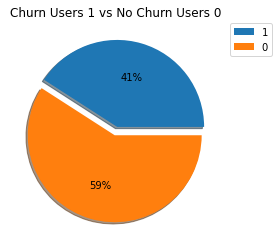

In [16]:
# churn plot
ax = df.select(["userId", "churn"]).dropDuplicates()\
    .groupBy("userId").agg(max("churn").alias("churn"))\
    .groupBy("churn").count()\
    .toPandas()\
    .set_index("churn")\
    .plot(
        kind='pie', y='count', autopct='%1.0f%%', 
        explode=[0.05, 0.05], legend=True, 
        title='Churn Users 1 vs No Churn Users 0', ylabel='', 
        shadow=True, labeldistance=None
    )

ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
plt.show()

We have an overall churn rate of about 41%. It seems the data is rather balanced with slightly more retained users. However this is not the training data used to fit the model. So to know whether we have imbalanced data or not we need to see the post-process training data.


Now as we see the timestamp column `ts`, what is the time span of the data we have?

In [17]:
get_date = udf(lambda x: \
    datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d")
)
df = df.withColumn("date", get_date(df.ts))
df.describe("date").filter("summary='min' or summary='max'").show()

+-------+----------+
|summary|      date|
+-------+----------+
|    min|2018-10-01|
|    max|2018-12-03|
+-------+----------+



Let's have a look at the stats for the number of daily users.

In [18]:
df.select(["userId", "date"]).dropDuplicates()\
    .groupBy("date").agg(countDistinct("userId")\
    .alias("daily users"))\
    .describe("daily users").show()

+-------+------------------+
|summary|       daily users|
+-------+------------------+
|  count|                63|
|   mean| 50.34920634920635|
| stddev|15.024881224541241|
|    min|                 1|
|    max|                72|
+-------+------------------+



How does the distribution of number of songs users listen to look like?

In [19]:
df.filter(df.page=="NextSong").groupBy("userId")\
    .count().describe("count").show()

+-------+------------------+
|summary|             count|
+-------+------------------+
|  count|               225|
|   mean|1013.8133333333334|
| stddev|1104.9607785540882|
|    min|                 3|
|    max|              8002|
+-------+------------------+



Text(0.5, 0, 'Number of Songs')

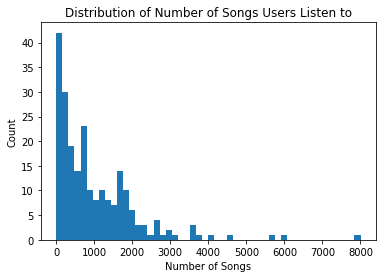

In [20]:
# plot 
fig, ax = plt.subplots()
hist(
    ax, 
    df.filter(df.page=="NextSong")\
        .groupBy("userId").count().select('count'), 
    bins = 50
)
ax.set_title("Distribution of Number of Songs Users Listen to")
ax.set_ylabel("Count")
ax.set_xlabel("Number of Songs")

It looks like we get some outliers, e.g the user who listened to 8002 songs. The outliers will be handled in the data preprocessing section.

In the `page` column, not only `NextSong` is interesting, many other values like `Downgrade`, `Thumbs Down`, `Add To Playlist` etc. So let's have a look at the distributions of all these pages.

In [21]:
page_df = df.groupBy(["userId", "page"]).count()\
    .groupBy("userId").pivot("page").sum("count")\
    .na.fill(0).describe()\
    .select([
        "summary",
        "Downgrade", 
        "Upgrade",
        "Submit Upgrade", 
        "Thumbs Down", 
        "Thumbs Up",
        "Add Friend",
        "Add to Playlist",
        "Roll Advert"
    ])
page_df.select([
    "summary", 
    *(col(c).cast("float").alias(c) for c in page_df.columns[1:])
]).show()

+-------+---------+---------+--------------+-----------+---------+----------+---------------+-----------+
|summary|Downgrade|  Upgrade|Submit Upgrade|Thumbs Down|Thumbs Up|Add Friend|Add to Playlist|Roll Advert|
+-------+---------+---------+--------------+-----------+---------+----------+---------------+-----------+
|  count|    225.0|    225.0|         225.0|      225.0|    225.0|     225.0|          225.0|      225.0|
|   mean| 9.133333|2.2177777|    0.70666665|  11.315556|55.782223| 19.008888|      29.004444|      17.48|
| stddev|11.734412| 2.558537|    0.73387426|  13.077481| 65.47793| 20.581717|      32.716656|  21.550207|
|    min|      0.0|      0.0|           0.0|        0.0|      0.0|       0.0|            0.0|        0.0|
|    max|     73.0|     15.0|           4.0|       75.0|    437.0|     143.0|          240.0|      128.0|
+-------+---------+---------+--------------+-----------+---------+----------+---------------+-----------+



We can see very high variance for Thumbs Up and Add to Playlist. We will do outlier detection for these columns in the data preprocessing section. Please note that we can do this for more columns but due to the high computational cost let's take just these two columns.

But how these page views relate to the churn of users? Remember that the overall churn rate is at about 41%.

In [22]:
# create df for the plots
churn_df = df.select(["userId", "churn"]).dropDuplicates()\
    .groupBy("userId").agg(max("churn").alias("churn"))

plot_df = df.groupBy(["userId", "page"]).count()\
    .groupBy("userId").pivot("page").sum("count")\
    .na.fill(0).join(churn_df, on="userId")\
    .select([
        "churn",
        "NextSong",
        "Downgrade", 
        "Upgrade",
        "Thumbs Down", 
        "Thumbs Up",
        "Submit Upgrade", 
        "Add Friend",
        "Add to Playlist",
        "Roll Advert"
    ])\
    .groupBy("churn").avg().toPandas().T\
    .drop("avg(churn)", axis=0)\
    .rename({"0": "churn 0", "1": "churn 1"})
plot_df.columns = ["churn 0", "churn 1"]
plot_df.index = [
    x.replace("avg(", "").replace(")", "") for x in plot_df.index
]
plot_df = plot_df.iloc[1:,:]
plot_df["ratio"] = round(
    plot_df["churn 1"]/(plot_df["churn 1"] + plot_df["churn 0"]), 
    2
)

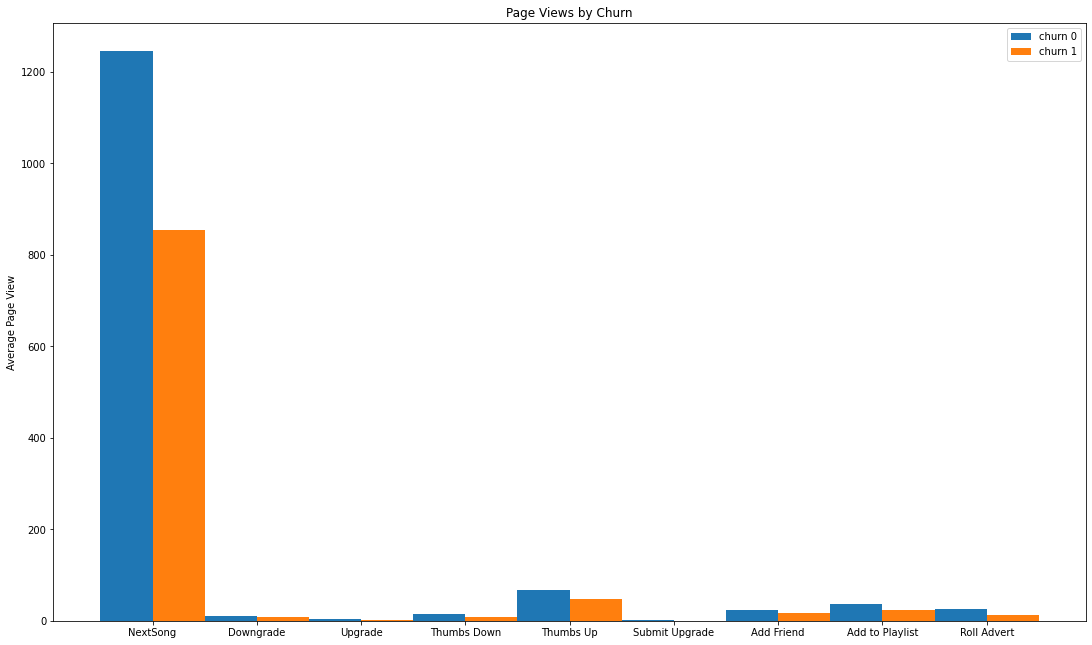

In [23]:
# plot 
labels = plot_df.index.to_list()

x = np.arange(len(labels))  # the label locations
width = 0.5  # the width of the bars

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 11)
rects1 = ax.bar(
    x - width/2, plot_df["churn 0"], width, label='churn 0'
)
rects2 = ax.bar(
    x + width/2, plot_df["churn 1"], width, label='churn 1'
)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Page View')
ax.set_title('Page Views by Churn')
ax.legend()
ax.set_xticks(x)
ax.set_xticklabels(labels)

plt.show()

Let's now look at the `level` column. The average number of days of a user being `paid` and `free` is shown as below by churn:

In [24]:
df.select(["userId", "level", "date"]).dropDuplicates()\
    .groupBy(["userId", "level"]).count()\
    .join(churn_df, on="userId")\
    .groupBy(["churn", "level"]).agg(avg("count").alias("avg_days"))\
    .groupBy("churn").pivot("level").sum("avg_days")\
    .show()

+-----+-----------------+------------------+
|churn|             free|              paid|
+-----+-----------------+------------------+
|    1|8.081395348837209|12.973684210526315|
|    0|5.513761467889908|12.393258426966293|
+-----+-----------------+------------------+



It looks like for `level = paid` there's no big difference between the churn and non-churn groups. However the users who churned seem to have stayed more `free` days than who didn't churn.

Now what about gender and its relation to churn rate?

In [25]:
# by gender
df.select(["userId", "gender", "churn"]).dropDuplicates()\
    .groupBy("userId", "gender").agg(
        max("churn").alias("churn"))\
    .groupBy("gender").agg(
        avg("churn").alias("churn rate"), 
        count("churn").alias("count")
    ).show()

+------+-------------------+-----+
|gender|         churn rate|count|
+------+-------------------+-----+
|     F|0.41346153846153844|  104|
|     M| 0.4049586776859504|  121|
+------+-------------------+-----+



The two genders have similar churn rates of about 40% with female slightly higher by ~1%.

Let's have a look at the top locations with most users. 

In [26]:
# split the location to get the state code
df = df.withColumn("location", split(col("location"), ",").getItem(1))

df.select(["userId", "location"]).dropDuplicates().na.fill("Null")\
    .filter(df.location.isNotNull())\
    .groupBy("location").count().sort(desc("count")).show(10)

+---------+-----+
| location|count|
+---------+-----+
|       CA|   33|
|       TX|   16|
| NY-NJ-PA|   15|
|       FL|   14|
|       AZ|    7|
|       CT|    7|
| IL-IN-WI|    6|
|    NC-SC|    6|
|    MO-IL|    6|
|       NC|    6|
+---------+-----+
only showing top 10 rows



In [27]:
# create df for the scatter plots
df.select(["userId", "location"]).dropDuplicates()\
    .join(churn_df, on="userId")\
    .groupBy("location").agg(
        avg("churn").alias("churn_rate"), 
        count("churn").alias("total_users")
    ).sort(desc("churn_rate")).show()

+------------+------------------+-----------+
|    location|        churn_rate|total_users|
+------------+------------------+-----------+
|       KY-IN|               1.0|          1|
|       IL-MO|               1.0|          1|
|       TN-VA|               1.0|          1|
|          UT|               1.0|          1|
|          AR|               1.0|          1|
|    TN-MS-AR|               1.0|          1|
|          OR|               1.0|          1|
| PA-NJ-DE-MD|               0.8|          5|
|          AL|              0.75|          4|
|          CO|              0.75|          4|
|          KY|0.6666666666666666|          3|
|          OH|0.6666666666666666|          3|
|          MS|0.6666666666666666|          3|
|       MA-NH|               0.6|          5|
|          MI|               0.6|          5|
|       MO-KS|               0.5|          2|
| DC-VA-MD-WV|               0.5|          4|
|       VA-NC|               0.5|          2|
|       RI-MA|               0.5| 

It is very hard to say if location plays a role here because of the little data we have for many locations. We will leave it out in the modeling.

## Methodology

### Features
Usually for churn prediction, we would want to look at customer demographic data, customer account info, product data etc. Here we have very little data (225 users), to avoid overfitting let's select just a few features to be evaluated on in the modeling section with some feature selection techniques.

From the previous data exploration, let's collect the following of a user as features.

Number of page visits: 

- NextSong 
- Downgrade 
- Upgrade 
- Thumbs Down 
- Thumbs Up 
- Submit Upgrade 
- Add Friend 
- Add to Playlist
- Roll Advert

And:
- gender
- number of days as `level = paid`
- number of days as `level = free`


In [28]:
feature_cols = [
    "gender",
    "NextSong",
    "Downgrade",
    "Upgrade",
    "Thumbs Down",
    "Thumbs Up",
    "Submit Upgrade",
    "Add Friend",
    "Add to Playlist",
    "Roll Advert",
    "free",
    "paid"
]

### Data Preprocessing
#### Data Manipulation
When we make churn prediction, we want to predict for the future the churn of users who haven't churned so far. So it is time sensitive. We have data of about 2 months, let's use a time window of 6 weeks with first 4 weeks for the input features and last 2 weeks for the target. This way we will get 2 batches and combine them.

In [29]:
# define function for preprocessing data
def process_data(df):
    '''preprocesses raw data into training data
    input:
        df - pyspark dataframe to process
    return:
        data - dataframe with input features and label
    '''
    min_date = datetime.datetime.strptime(
        df.agg({"date": "min"}).collect()[0]["min(date)"],
        "%Y-%m-%d")
    max_date = datetime.datetime.strptime(
        df.agg({"date": "max"}).collect()[0]["max(date)"],
        "%Y-%m-%d")
    # how many batches of training data we have for y
    # (total days - first 4 weeks) / 14 days(one batch)
    n_batch = math.floor(((max_date - min_date).days - 4*7)/14)
    # use list to combine all results
    data_list = []
    
    for i in range(n_batch):
        date_1 = min_date + datetime.timedelta(days=i*14) # start for X
        date_2 = date_1 + datetime.timedelta(days=4*7) # end for X and start for y
        date_3 = date_2 + datetime.timedelta(days=14) # end for y

        users_churned = df.filter(
            (df.date>=date_1) & (df.date<date_2) & (df.churn==1))\
            .select("userId").dropDuplicates()\
            .rdd.flatMap(lambda x: x).collect()

        df_tmp = df.filter(
            (df.date>=date_1) & (df.date<date_2) & \
            (~df.userId.isin(users_churned)))

        X_page = df_tmp.groupBy(["userId", "gender", "page"]).count()\
            .groupBy(["userId", "gender"]).pivot("page").sum("count")\
            .na.fill(0).select([
                "userId",
                "gender",
                "NextSong",
                "Downgrade",
                "Upgrade",
                "Thumbs Down",
                "Thumbs Up",
                "Submit Upgrade",
                "Add Friend",
                "Add to Playlist",
                "Roll Advert"
            ]).withColumn(
                "gender", when(col("gender")=='F', 1
            ).otherwise(0))

        X_level = df_tmp.select(
            ["userId", "level", "date"]).dropDuplicates()\
            .groupBy(["userId", "level"]).count()\
            .groupBy("userId").pivot("level").sum("count")\
            .na.fill(0)

        combined = df.filter(
            ((df.date>=date_2) & (df.date<date_3)) & (df.churn==1))\
            .select("userId").dropDuplicates()\
            .withColumn("churn", lit(1))\
            .join(X_page, on="userId", how="outer")\
            .na.fill(0, subset=["churn"])\
            .join(X_level, on="userId")\
            .drop("userId")

        data_list.append(combined)

    # union all data for each time window
    data = reduce(DataFrame.union, data_list)\
        .withColumnRenamed("churn", "label")

    return data

In [30]:
data = process_data(df)

#### Outliers

As mentioned earlier, there might be outliers in our dataset. Let's detect and remove them to make the training set more representative of the population.

In [31]:
# remove outliers for train
# find the lower and upper bounds for each column
bounds = {
    c: dict(
        zip(["q1", "q3"], data.approxQuantile(c, [0.25, 0.75], 0))
    )
    for c in ["NextSong", "Thumbs Up", "Add to Playlist"]
}

for c in bounds:
    iqr = bounds[c]['q3'] - bounds[c]['q1']
    bounds[c]['lower'] = bounds[c]['q1'] - (iqr * 1.5)
    bounds[c]['upper'] = bounds[c]['q3'] + (iqr * 1.5)

# remove rows with outliers
data = data.filter(
    (col("NextSong").between(
        bounds["NextSong"]['lower'], 
        bounds["NextSong"]['upper'])
    ) &
    (col("Thumbs Up").between(
        bounds["Thumbs Up"]['lower'], 
        bounds["Thumbs Up"]['upper'])
    ) &
    (col("Add to Playlist").between(
        bounds["Add to Playlist"]['lower'], 
        bounds["Add to Playlist"]['upper']
    ))
)

#### Imbalanced dataset

In [32]:
data.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|  255|
|    1|   28|
+-----+-----+



The training data we generated from the dataset is highly imbalanced. This might or might not be due to the small dataset we have. Neverthless let's apply oversampling to the dataset and simulate more `label=1` data. Note that there are other better techniques e.g SMOTE or using cost functions when modeling for this purpose. But here for simplicity we will use `sample` method of pyspark dataframe for oversampling.

In [33]:
data_0 = data.filter("label == 0")
data_1 = data.filter("label == 1")
f = data_0.count()/data_1.count()
data_1_over = data_1.sample(
    withReplacement=True, fraction=f, seed=42
)
data = data_0.union(data_1_over)
data.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|  255|
|    1|  252|
+-----+-----+



In [34]:
# train test split
split = data.randomSplit([0.8, 0.2], seed=42)
train, test = split[0], split[1]

### Modelling and Evaluation

Our churn prediction is a binary classification problem. There are many machine learning models can be used. I will start with logisitic regression as a baseline model and then predict with Random Forest and Naive-Bayes classifiers.

In [35]:
# build pipeline
# vectorize features
assembler = VectorAssembler(
    inputCols=feature_cols, outputCol="assembled"
)
# standardize feature values
scaler = StandardScaler(inputCol="assembled", outputCol="scaled")
# select best features
selector = UnivariateFeatureSelector(
    featuresCol="scaled",
    outputCol="features")
selector.setFeatureType("continuous").setLabelType("categorical")
# define the 3 algorithms
gbt = GBTClassifier(maxIter=5, labelCol="label", seed=42)
lr =  LogisticRegression(maxIter=10, elasticNetParam=0)
dt = DecisionTreeClassifier()
nb = NaiveBayes()

# define parameters to evaluate
paramGrid_gbt = ParamGridBuilder() \
    .addGrid(selector.selectionMode, ["numTopFeatures", "fpr"])\
    .addGrid(gbt.maxDepth, [4, 5, 6]) \
    .build()

paramGrid_lr = ParamGridBuilder() \
    .addGrid(selector.selectionMode, ["numTopFeatures", "fpr"])\
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .build()

paramGrid_dt = ParamGridBuilder() \
    .addGrid(selector.selectionMode, ["numTopFeatures", "fpr"])\
    .addGrid(dt.maxDepth, [3, 4, 5]) \
    .build()

paramGrid_nb = ParamGridBuilder() \
    .addGrid(selector.selectionMode, ["numTopFeatures", "fpr"])\
    .addGrid(nb.smoothing, [1, 0.1, 0.01]) \
    .build()

# loop over the 3 models
model_names = [
    "Logistic Regression",
    "Gradient Boosted Trees",
    "Decision Tree",
    "Naive Bayes"
]
model_list = [lr, gbt, dt, nb]
paramGrid_list = [
    paramGrid_lr, paramGrid_gbt, paramGrid_dt, paramGrid_nb
]
for i in range(4):
    pipeline = Pipeline(
        stages=[assembler, scaler, selector, model_list[i]])
    paramGrid = paramGrid_list[i]

    # find best parameters with cross validation
    crossval = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=paramGrid,
        evaluator=BinaryClassificationEvaluator(),
        numFolds=5) 

    cvModel = crossval.fit(train)
    # Make predictions on test data
    pred = cvModel.transform(test)

    # Create evaluator
    evaluator = MulticlassClassificationEvaluator(
        labelCol="label", predictionCol="prediction"
    )
    pred_label = pred.select("label", "prediction")
    # Get metrics
    acc = evaluator.evaluate(
        pred_label, {evaluator.metricName: "accuracy"})
    f1 = evaluator.evaluate(
        pred_label, {evaluator.metricName: "f1"})
    weightedPrecision = evaluator.evaluate(
        pred_label, {evaluator.metricName: "weightedPrecision"}
    )
    weightedRecall = evaluator.evaluate(
        pred_label, {evaluator.metricName: "weightedRecall"}
    )
    evaluator = BinaryClassificationEvaluator(
        labelCol="label", 
        rawPredictionCol="prediction", 
        metricName='areaUnderROC'
    )
    auc = evaluator.evaluate(pred_label)
    print(model_names[i])
    print(f"accuracy: {acc}")
    print(f"precision: {weightedPrecision}")
    print(f"recall: {weightedRecall}")
    print(f"f1 score: {f1}")
    print(f"AUC: {auc}\n")


Logistic Regression
accuracy: 0.7368421052631579
precision: 0.7556696619597774
recall: 0.736842105263158
f1 score: 0.7362003278898943
AUC: 0.7455277280858675

Gradient Boosted Trees
accuracy: 0.9578947368421052
precision: 0.9609022556390978
recall: 0.9578947368421054
f1 score: 0.9576475062996245
AUC: 0.9534883720930233

Decision Tree
accuracy: 0.8736842105263158
precision: 0.8773422918999627
recall: 0.8736842105263158
f1 score: 0.8739649122807016
AUC: 0.8765652951699464

Naive Bayes
accuracy: 0.6421052631578947
precision: 0.6518998029833944
recall: 0.6421052631578947
f1 score: 0.6424225457260172
AUC: 0.6469141323792487



The gradient boosted tree model outperforms the other three across all the chosen 5 metrics (AUC ~92%). Let's save the model to a file.

In [36]:
# train gbt
pipeline = Pipeline(
    stages=[assembler, scaler, selector, gbt]
)

crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid_gbt,
    evaluator=BinaryClassificationEvaluator(),
    numFolds=5) 

cvModel = crossval.fit(data) # let's use all data to train the model

In [ ]:
# save model
cvModel.write().save("gbt")

## Conclusion

### Summary

In this notebook, we have 

- explored the dataset and gained an overview of different columns
- performed analysis to find potential features for churn prediction
- preprocessed dataset to generate training data
- compared three machine learning algorithms and
- evaluated the performances and tuned hypeparameters with cross validation
- calculated evaluation metrics on the test dataset

We have also performed various techniques e.g oversampling, outlier detection, standardization, feature selection etc.

In the end, we found the gradient booted trees algorithm to be the best performing model with accuracy, precision, recall, f1 score and AUC, all of which is above 93%.


### Improvement
There are several areas I would like to emphasize for further improvements. 

- As mentioned earlier, there are better ways to handle imbalanced dataset. Our dataset is very small and we used oversampling, where a better approach could be SMOTE. With the full dataset, you might want to use downsampling or cluster the abundant class or a completely different approach on the model itself, e.g designing the cost function.
- We could have done a better job in the feature engineering. When we have a bigger dataset, include more info as features, do correlation analysis, perform PCA, dig more into feature selectors etc. 
- More algorithms can be evaluated although the gradient boosted trees model looks promising.
